In [175]:
import pandas as pd
from ast import literal_eval
from collections import Counter
import collections
import matplotlib.pylab as plt
import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import operator
import statistics
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
profiles = pd.read_csv("linkedin_profiles.csv")

profiles.experiences = profiles.experiences.apply(literal_eval)
profiles.educations = profiles.educations.apply(literal_eval)
profiles.licenses_and_certificates = profiles.licenses_and_certificates.apply(literal_eval)
profiles.skills = profiles.skills.apply(literal_eval)

In [3]:
profiles.head()

,headline,location,no_of_connections,about,experiences,educations,licenses_and_certificates,skills
0,Data Analyst at TBWA\The Disruption Company | ...,Singapore,500+ connections,"I am currently at TBWA,Singapore helping adver...","[{'title': 'Data Analyst', 'company': 'TBWA\ G...","[{'school': 'Singapore Management University',...",[{'name': 'DoubleClick Campaign Manager Fundam...,"[Databases, Business Analysis, Data Structures..."
1,Senior Data Analyst at Publicis Singapore,Singapore,339 connections,Uncovering insights and trends for the consume...,"[{'title': 'Senior Data Analyst, Strategy', 'c...","[{'school': 'RMIT University', 'type': 'Bachel...","[{'name': 'Intro to SQL for Data Science', 'pr...","[Business Analytics, Data Visualization, Socia..."
2,Senior Data Analyst at Shopee,Singapore,463 connections,Timothy has a huge passion for data analytics....,"[{'title': 'Senior Data Analyst', 'company': '...","[{'school': 'Singapore Management University',...","[{'name': 'Six Sigma Green Belt', 'provider': ...",[]
3,Data Analyst at GovTech,Singapore,147 connections,• Lead a team of 20+ patrol officers at a Neig...,"[{'title': 'Data Analyst, Data Science & Artif...","[{'school': 'Harvard University', 'type': 'Mas...","[{'name': 'Exploratory Data Analysis', 'provid...","[R, Investigation, Statistical Data Analysis, ..."
4,Data Analyst at Energy Aspects,Singapore,307 connections,mining and deep learning.,"[{'title': 'Data Analyst', 'company': 'Energy ...",[{'school': 'National University of Singapore'...,"[{'name': '计算导论与C语言基础', 'provider': 'Coursera'...","[SQL, R, Python, Data Analysis, Data Mining, M..."


### Total Number of Profiles

In [4]:
print(len(profiles))

534


### Connections Distribution

In [12]:
no_of_connections_raw = profiles["no_of_connections"].tolist()

In [62]:
def remove_connections_word(text):
    text = text.replace(' connections', '')
    text = text.replace(' connection', '')
    text = text.replace('500+', str(501))
    return text

In [22]:
no_of_connections = [remove_connections_word(item) for item in no_of_connections_raw]

In [24]:
no_of_connections[:5]

['501', '339', '463', '147', '307']

In [81]:
def convert_to_range(connection):
    if int(connection) <= 50:
        return "0-50"
    elif int(connection) > 50 and int(connection) <= 100:
        return "51-100"
    elif int(connection) > 100 and int(connection) <= 150:
        return "101-150"
    elif int(connection) > 150 and int(connection) <= 200:
        return "151-200"
    elif int(connection) > 200 and int(connection) <= 250:
        return "201-250"
    elif int(connection) > 250 and int(connection) <= 300:
        return "251-300"
    elif int(connection) > 300 and int(connection) <= 350:
        return "301-350"
    elif int(connection) > 350 and int(connection) <= 400:
        return "351-400"
    elif int(connection) > 400 and int(connection) <= 450:
        return "401-450"
    elif int(connection) > 450 and int(connection) <= 500:
        return "451-500"
    else:
        return "501+"

In [82]:
no_of_connections_range = [convert_to_range(item) for item in no_of_connections]

In [83]:
no_of_connections_range[:5]

['501+', '301-350', '451-500', '101-150', '301-350']

In [84]:
connections_count = Counter(no_of_connections_range)

In [85]:
connections_count

Counter({'501+': 275,
         '301-350': 26,
         '451-500': 20,
         '101-150': 26,
         '401-450': 20,
         '251-300': 25,
         '151-200': 41,
         '351-400': 35,
         '51-100': 25,
         '201-250': 27,
         '0-50': 14})

In [86]:
connections_count_list = sorted(connections_count.items())
x, y = zip(*connections_count_list)

In [87]:
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(x))
    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    plt.rcParams['figure.figsize'] = 10, 5
    plt.bar(index, y)
    plt.xlabel('Number of Connections', fontsize=10)
    plt.xticks(index, x, fontsize=10, rotation=30)
    plt.title('Connections Distribution')
    plt.show()

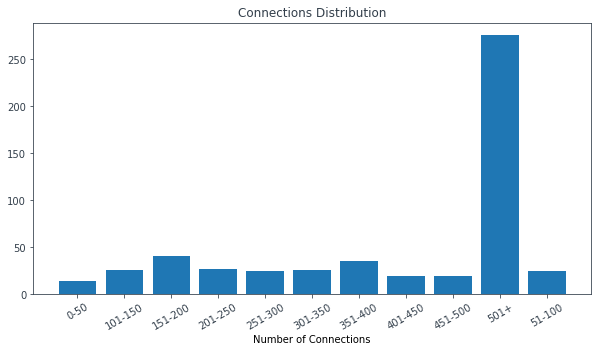

In [175]:
plot_bar_x()

### WordCloud on Headline and About Section

In [113]:
# COMBINE ALL HEADLINE AND ABOUT SECTIONS INTO ONE STRING
headline_combined = " ".join(str(headline) for headline in profiles.headline)
about_combined = " ".join(str(about) for about in profiles.about)
print ("There are {} words in the combination of all headline sections.".format(len(headline_combined)))
print ("There are {} words in the combination of all about sections.".format(len(about_combined)))

combined_text = headline_combined + " " + about_combined

There are 21637 words in the combination of all headline sections.
There are 321850 words in the combination of all about sections.


In [114]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["Singapore", "data", "analyst", "scientist", "analysis", "analyst", "science", "machine", "learning", "analytic", "analytics"])

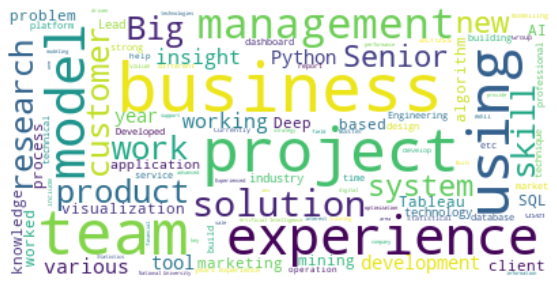

In [125]:
# Display the generated image:
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white").generate(combined_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Length of About Section

In [15]:
about = profiles['about']
length = []

for abt in about:
    try:
        tokens = abt.split(" ")
        length.append(len(tokens))
    except:
        length.append(0)

In [26]:
print("Max length: ", max(length))
print("75th percentile length: ", np.percentile(np.array(length), 75))
print("Median length: ", int(statistics.median(length)))
print("25th percentile length: ", np.percentile(np.array(length), 25))
print("Mean length: ", int(statistics.mean(length)))

Max length:  310
75th percentile length:  112.75
Median length:  70
25th percentile length:  40.0
Mean length:  81


### Education Distribution

In [45]:
all_educations = profiles['educations']

In [46]:
all_schools = []
all_types = []
all_courses = []

for educations in all_educations:
    for education in educations:
        try:
            all_schools.append(education['school'])
        except:
            all_schools.append("Nil")
        try:
            all_types.append(education['type'])
        except:
            all_types.append("Nil")
        try:
            all_courses.append(education['course'])
        except:
            all_courses.append("Nil")

In [228]:
all_schools_count = Counter(all_schools)
all_schools_count_sorted = sorted(all_schools_count.items(), key=lambda kv: kv[1])

In [233]:
all_schools_count_sorted

[('Jaypee Institute of Information Technology', 1),
 ('Technische Universität München', 1),
 ('Harvard University', 1),
 ('HBX | Harvard Business School', 1),
 ('Nanyang Junior college', 1),
 ("Xi'an Jiaotong University", 1),
 ('Stockholm School of Economics', 1),
 ('Higher School of Economics', 1),
 ('IEDC-Poslovna šola Bled', 1),
 ('The University of Queensland', 1),
 ('HEC School of Management / HEC Paris', 1),
 ('London School of Economics and Political Science', 1),
 ('Melbourne Business School', 1),
 ('Raffles Junior College, Singapore', 1),
 ('ZHAW School of Management and Law', 1),
 ('National Institute of Education, Singapore', 1),
 ('University of Leeds', 1),
 ('ACCA', 1),
 ('Oxford Brookes University', 1),
 ('LNMIIT', 1),
 ('Hogeschool Inholland / Inholland University of Applied Sciences', 1),
 ('Anglo Chinese School (Independent)', 1),
 ('MITx on edX', 1),
 ('SMA Santo Aloysius Bandung', 1),
 ('Carnegie Mellon University - Tepper School of Business', 1),
 ('Renmin Universit

In [241]:
schools = []
schools_count = []
for item in all_schools_count_sorted:
    if item[1] > 5:
        schools.append(item[0])
        schools_count.append(item[1])

In [242]:
print(schools[:5])
print(schools_count[:5])

['RMIT University', 'Meridian Junior College', 'The Hong Kong University of Science and Technology', 'National Junior College', 'The Australian National University']
[6, 6, 6, 6, 6]


In [243]:
def plot_bar_schools():
    # this is for plotting purpose
    index = np.arange(len(schools))
    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    plt.rcParams['figure.figsize'] = 15, 5
    plt.bar(index, schools_count)
    plt.xlabel('Schools', fontsize=10)
    plt.xticks(index, schools, fontsize=8, rotation=90)
    plt.title('Schools Distribution')
    plt.show()

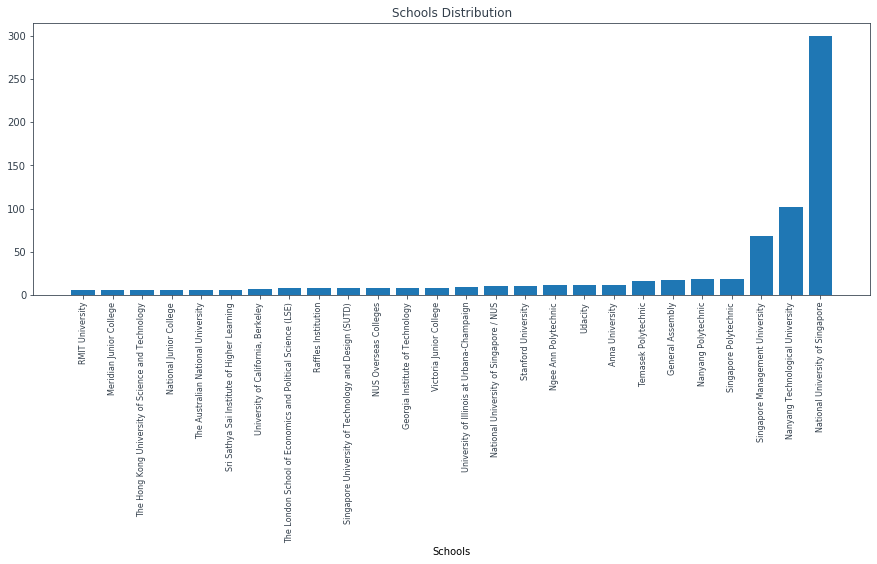

In [244]:
plot_bar_schools()

In [48]:
all_courses

['Nil',
 'Computer Science and Engineering',
 'Nil',
 'Nil',
 'Marketing',
 'Specialist Diploma in Business & Big Data Analytics',
 'Retail & Travel Management',
 '1st Major: Finance, 2nd Major: Operation Management',
 'Data Science',
 'Nil',
 'Statistics',
 'Econometrics and Mathematical Economics',
 'Nil',
 'Nil',
 'Statistics',
 'Statistics (specialization in business and finance)',
 'Big Data',
 'Analytics',
 'Nil',
 'Software Development',
 'Master of IT in Business (Analytics)',
 'Accounting',
 'Science',
 'Business Analytics and Information Technology',
 'Science Stream',
 'Industrial Systems Engineering & Management',
 'Mechanical Engineering',
 'Business and Economics with specialization in Management',
 'Economics with specialization in Corporate Finance',
 'Management',
 'Statistics and Economics',
 'Nil',
 'Computer Software Engineering',
 'Computer Software Engineering',
 'Software Engineering',
 'Data Science Immersive',
 'Nil',
 'Accounting and Finance',
 'Economics',
 '

### Experiences

In [41]:
all_experiences = profiles['experiences']

In [42]:
all_experiences[:5]

0    [{'title': 'Data Analyst', 'company': 'TBWA\ G...
1    [{'title': 'Senior Data Analyst, Strategy', 'c...
2    [{'title': 'Senior Data Analyst', 'company': '...
3    [{'title': 'Data Analyst, Data Science & Artif...
4    [{'title': 'Data Analyst', 'company': 'Energy ...
Name: experiences, dtype: object

In [43]:
all_current_titles = []
for experience in all_experiences:
    try:
        all_current_titles.append(experience[0]['title'])
    except:
        all_current_titles.append("Nil")

In [44]:
all_current_titles[:5]

['Data Analyst',
 'Senior Data Analyst, Strategy',
 'Senior Data Analyst',
 'Data Analyst, Data Science & Artificial Intelligence Division',
 'Data Analyst']

In [45]:
all_titles_count = Counter(all_current_titles)

In [46]:
all_titles_count_sorted = sorted(all_titles_count.items(), key=lambda kv: kv[1])

In [47]:
all_titles_count_sorted

[('Senior Data Analyst, Strategy', 1),
 ('Data Analyst, Data Science & Artificial Intelligence Division', 1),
 ('Group Customer Analytics and Decisioning - Data Analyst', 1),
 ('Senior Data Analyst, Business Intelligence', 1),
 ('Regional BI Data Analyst Team Lead', 1),
 ('Business and data analyst', 1),
 ('Senior Regional Business Intelligence and Data Analyst', 1),
 ('Senior Associate, Data & Shopper Intelligence', 1),
 ('Data Analytics Lead - Insurance', 1),
 ('Data Analyst II', 1),
 ('Lead Analyst (Manager)', 1),
 ('Business Analyst, Data Analytics, Global Banking', 1),
 ('Business Program Manager (Business, Finance and Data Analyst)', 1),
 ('Data Analyst & Developer', 1),
 ('Data Engineering and Business Analysis Lead', 1),
 ('Regional Senior Data Analyst - Analytics', 1),
 ('Senior Analyst, Customer Data Analytics', 1),
 ('Data Analyst (Campaigns)', 1),
 ('Regional Pricing and Data Analyst', 1),
 ('Data Analyst, Customer Analytics & Decision Sciences', 1),
 ('Big Data Consultant 

In [48]:
titles = []
titles_count = []
for item in all_titles_count_sorted:
    if item[1] > 2:
        titles.append(item[0])
        titles_count.append(item[1])

In [49]:
def plot_bar_titles():
    # this is for plotting purpose
    index = np.arange(len(titles))
    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    plt.rcParams['figure.figsize'] = 15, 5
    plt.bar(index, titles_count)
    plt.xlabel('Positions', fontsize=10)
    plt.xticks(index, titles, fontsize=8, rotation=90)
    plt.title('Position Distribution')
    plt.show()

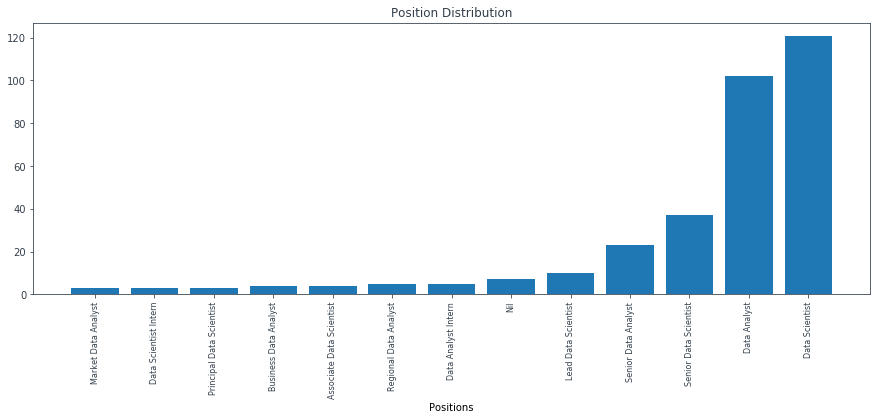

In [50]:
plot_bar_titles()

In [29]:
all_current_companies = []
for experience in all_experiences:
    try:
        all_current_companies.append(experience[0]['company'])
    except:
        all_current_companies.append("Nil")

In [30]:
all_current_companies[:5]

['TBWA\\ Group Singapore',
 'Publicis Singapore',
 'Shopee',
 'GovTech Singapore',
 'Energy Aspects']

In [33]:
all_companies_count = Counter(all_current_companies)
all_companies_count_sorted = sorted(all_companies_count.items(), key=lambda kv: kv[1])

In [34]:
all_companies_count_sorted

[('TBWA\\ Group Singapore', 1),
 ('Publicis Singapore', 1),
 ('Energy Aspects', 1),
 ('Levi Strauss & Co.', 1),
 ('CARIUMA', 1),
 ('Fundnel Limited', 1),
 ('Changi Airport Group', 1),
 ('ExxonMobil', 1),
 ('JurongHealth Campus', 1),
 ('Viki, Inc.', 1),
 ('Credit Suisse', 1),
 ('Circles.Life', 1),
 ('MG Asia', 1),
 ('MoneySmart Group', 1),
 ('Ministry of Education, Singapore (MOE)', 1),
 ('CIMB', 1),
 ('ST Electronics (Info-Software Systems) Pte. Ltd.', 1),
 ('Yuanfudao', 1),
 ('Wipro Limited', 1),
 ('Sompo Holdings (Asia)', 1),
 ('GREAT EASTERN', 1),
 ('Hewlett Packard Enterprise', 1),
 ('Total eBiz Solutions Pte Ltd', 1),
 ('MOH Holdings Pte Ltd (Singapore)', 1),
 ('Ebiquity plc', 1),
 ('Apple', 1),
 ('Wilmar International', 1),
 ('Trakomatic Pte Ltd', 1),
 ('Ascendas-Singbridge', 1),
 ('bitwallet', 1),
 ('B2B Gene', 1),
 ('TripAdvisor', 1),
 ('Citibank NA', 1),
 ('Ogilvy', 1),
 ('ESET', 1),
 ('Sephora SEA', 1),
 ('DataSpark', 1),
 ('Course5i', 1),
 ('PSA Singapore', 1),
 ('SIM Global

In [38]:
companies = []
companies_count = []
for item in all_companies_count_sorted:
    if item[1] > 2:
        companies.append(item[0])
        companies_count.append(item[1])

In [39]:
print(companies[:5])
print(companies_count[:5])

['Microsoft', 'Aon Centre for Innovation and Analytics (ACIA)', 'HOOQ', 'AXA', 'NCS Group']
[3, 3, 3, 3, 3]


In [43]:
def plot_bar_companies():
    # this is for plotting purpose
    index = np.arange(len(companies))
    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    plt.rcParams['figure.figsize'] = 15, 5
    plt.bar(index, companies_count)
    plt.xlabel('Companies', fontsize=10)
    plt.xticks(index, companies, fontsize=8, rotation=90)
    plt.title('Company Distribution')
    plt.show()

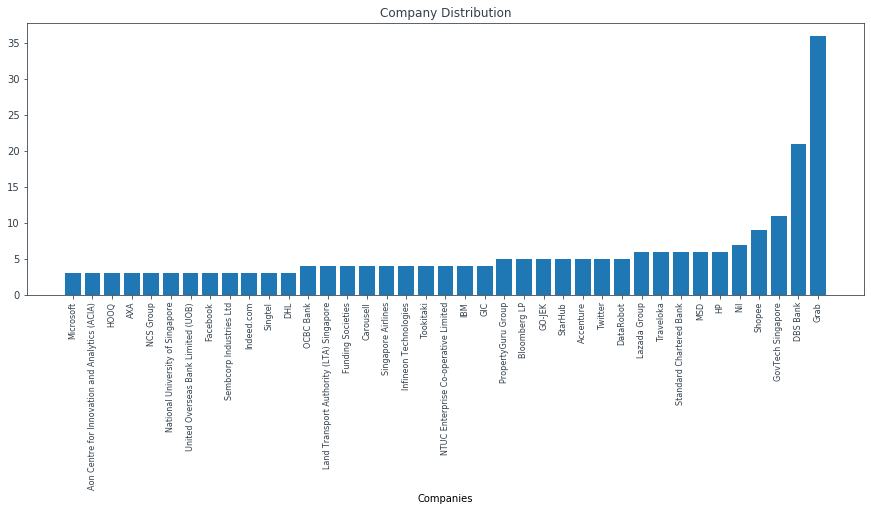

In [44]:
plot_bar_companies()

### Skills Distribution

In [134]:
all_skills = profiles['skills']

In [135]:
all_skills[:5]

0    [Databases, Business Analysis, Data Structures...
1    [Business Analytics, Data Visualization, Socia...
2                                                   []
3    [R, Investigation, Statistical Data Analysis, ...
4    [SQL, R, Python, Data Analysis, Data Mining, M...
Name: skills, dtype: object

In [136]:
all_skills_expanded = []
for skills in all_skills:
    for skill in skills:
        all_skills_expanded.append(skill)
        
all_skills_expanded[:10]

['Databases',
 'Business Analysis',
 'Data Structures',
 'Analytical Skills',
 'Project Management',
 'Event Management',
 'Data Analysis',
 'Market Analysis',
 'Management Consulting',
 'Web Analytics']

In [140]:
skills_count = Counter(all_skills_expanded)

In [165]:
skills_count_sorted = sorted(skills_count.items(), key=lambda kv: kv[1])

In [206]:
skills = []
skills_count = []
for item in skills_count_sorted:
    if item[1] > 30:
        skills.append(item[0])
        skills_count.append(item[1])

In [207]:
print(skills[:5])
print(skills_count[:5])

['Natural Language Processing (NLP)', 'Time Series Analysis', 'Requirements Analysis', 'Strategy', 'Customer Service']
[31, 31, 32, 32, 32]


In [214]:
def plot_bar_skills():
    # this is for plotting purpose
    index = np.arange(len(skills))
    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    plt.rcParams['figure.figsize'] = 15, 5
    plt.bar(index, skills_count)
    plt.xlabel('Skills', fontsize=10)
    plt.xticks(index, skills, fontsize=8, rotation=90)
    plt.title('Skills Distribution')
    plt.show()

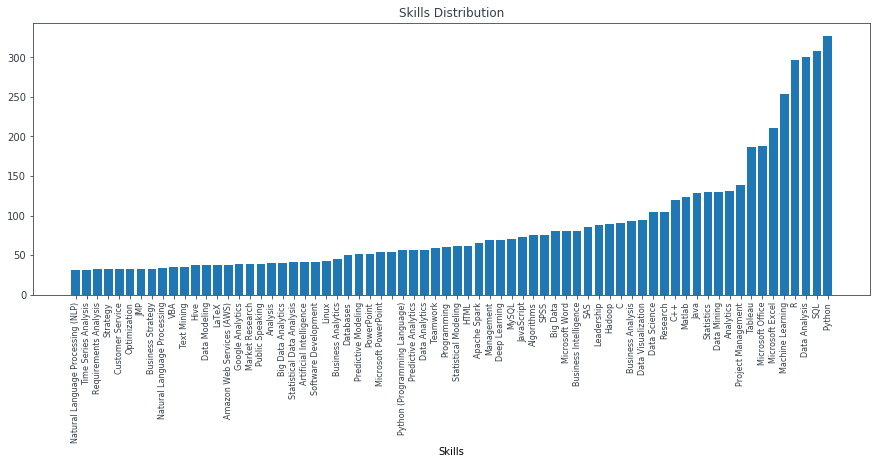

In [215]:
plot_bar_skills()

### Licenses and Certificates

In [49]:
all_lanc = profiles['licenses_and_certificates']

In [50]:
all_lanc.head()

0    [{'name': 'DoubleClick Campaign Manager Fundam...
1    [{'name': 'Intro to SQL for Data Science', 'pr...
2    [{'name': 'Six Sigma Green Belt', 'provider': ...
3    [{'name': 'Exploratory Data Analysis', 'provid...
4    [{'name': '计算导论与C语言基础', 'provider': 'Coursera'...
Name: licenses_and_certificates, dtype: object

In [58]:
all_lanc_expanded = []
for lancs in all_lanc:
    for lanc in lancs:
        try:
            all_lanc_expanded.append(lanc['name'] + " --> " + lanc['provider'])
        except:
            all_lanc_expanded.append("Nil")

In [59]:
all_lanc_expanded[:5]

['DoubleClick Campaign Manager Fundamentals --> DoubleClick',
 'DoubleClick Bid Manager Fundamentals | 87% --> DoubleClick',
 'R Programming,Grade Achieved: 97.0% --> Coursera Course Certificates',
 'AMCAT Certified in English Comprehension --> Aspiring Minds',
 'AMCAT Certified Business Analyst --> Aspiring Minds']

In [60]:
all_lanc_count = Counter(all_lanc_expanded)
all_lanc_count_sorted = sorted(all_lanc_count.items(), key=lambda kv: kv[1])

In [70]:
all_lanc_count_sorted[-5:]

[('Structuring Machine Learning Projects --> Coursera', 23),
 ('Machine Learning --> Coursera', 26),
 ('Improving Deep Neural Networks: Hyperparameter tuning, Regularization and Optimization --> Coursera',
  26),
 ('Neural Networks and Deep Learning --> Coursera', 30),
 ('Nil', 226)]

In [71]:
del all_lanc_count_sorted[-1]

In [72]:
all_lanc_count_sorted[-5:]

[('Deep Learning Specialization --> Coursera', 21),
 ('Structuring Machine Learning Projects --> Coursera', 23),
 ('Machine Learning --> Coursera', 26),
 ('Improving Deep Neural Networks: Hyperparameter tuning, Regularization and Optimization --> Coursera',
  26),
 ('Neural Networks and Deep Learning --> Coursera', 30)]

In [76]:
lanc = []
lanc_count = []
for item in all_lanc_count_sorted:
    if item[1] >= 5:
        lanc.append(item[0])
        lanc_count.append(item[1])

In [79]:
def plot_bar_lanc():
    # this is for plotting purpose
    index = np.arange(len(lanc))
    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    plt.rcParams['figure.figsize'] = 15, 5
    plt.bar(index, lanc_count)
    plt.xlabel('Licenses and Certificates', fontsize=10)
    plt.xticks(index, lanc, fontsize=8, rotation=90)
    plt.title('Licenses and Certificates Distribution')
    plt.show()

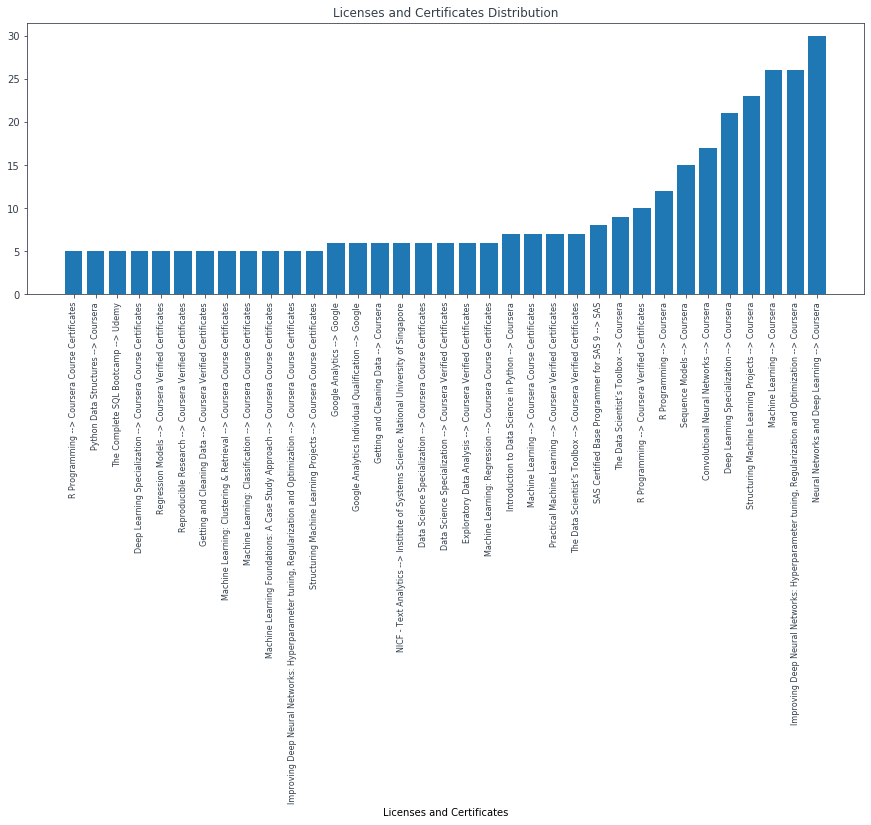

In [80]:
plot_bar_lanc()

## Job Position Analysis

##### Interested to find out Data Analyst, Data Scientist + Senior Positions

In [4]:
all_experiences = profiles['experiences']
all_educations = profiles['educations']
all_skills = profiles['skills']
all_landc = profiles['licenses_and_certificates']
all_experiences = profiles['experiences']

#### Data Scientist

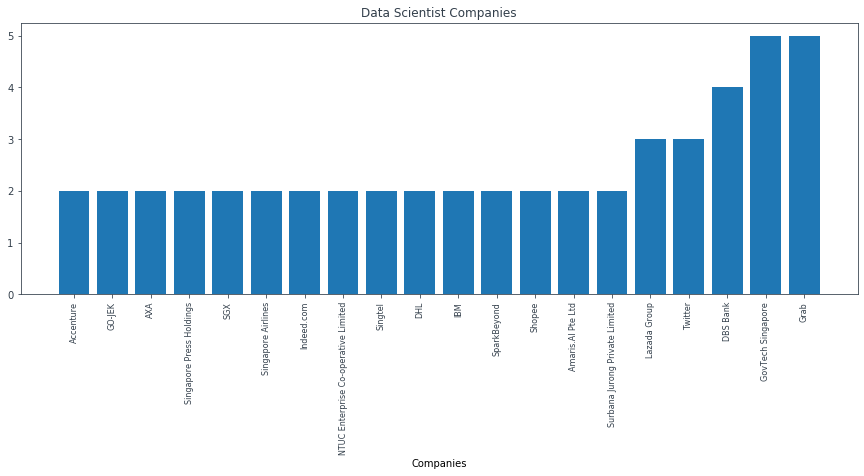

In [67]:
data_scientist_company = []

for i in range(len(all_experiences)):
    
    try:
        if all_experiences[i][0]['title'] == "Data Scientist":
            data_scientist_company.append(all_experiences[i][0]['company'])
            
    except:
        pass
    
    
data_scientist_company_count = Counter(data_scientist_company)
data_scientist_company_count_sorted = sorted(data_scientist_company_count.items(), key=lambda kv: kv[1])


ds_company = []
ds_company_count = []
for item in data_scientist_company_count_sorted[-20:]:
    ds_company.append(item[0])
    ds_company_count.append(item[1])
    
    
def plot_bar_companies():
    # this is for plotting purpose
    index = np.arange(len(ds_company))
    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    plt.rcParams['figure.figsize'] = 15, 5
    plt.bar(index, ds_company_count)
    plt.xlabel('Companies', fontsize=10)
    plt.xticks(index, ds_company, fontsize=8, rotation=90)
    plt.title('Data Scientist Companies')
    plt.show()
    
    
plot_bar_companies()

In [11]:
data_scientist_school = []
data_scientist_course_type = []
data_scientist_course = []

for i in range(len(all_experiences)):
    
    try:
        if all_experiences[i][0]['title'] == "Data Scientist":
            data_scientist_school.append(all_educations[i][0]['school'])
            data_scientist_course_type.append(all_educations[i][0]['type'])
            data_scientist_course.append(all_educations[i][0]['course'])
            
    except:
        pass

In [12]:
data_scientist_course_type_phd_count = 0
data_scientist_course_type_masters_count = 0
data_scientist_course_type_bachelor_count = 0
data_scientist_course_type_others_count = 0

for course_type in data_scientist_course_type:
    
    #MASTERS
    if "Master" in course_type or "MPhil" in course_type or "MTech" in course_type or "M.Tech" in course_type or "M.Phil." in course_type or "MA" in course_type or "MS" in course_type:
        data_scientist_course_type_masters_count += 1
    #PHD
    elif "Doctor" in course_type or "PhD" in course_type or "Ph.D." in course_type:
        data_scientist_course_type_phd_count += 1
    #BACHELOR
    elif "Bachelor" in course_type or "BSE" in course_type or "B.Tech" in course_type or "BA" in course_type in course_type:
        data_scientist_course_type_bachelor_count += 1
    #OTHERS
    else:
        data_scientist_course_type_others_count += 1

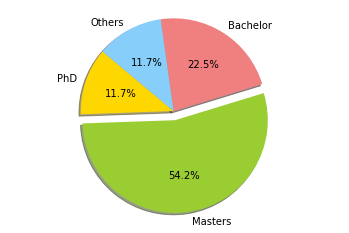

In [16]:
# Data to plot
labels = 'PhD', 'Masters', 'Bachelor', 'Others'
sizes = [data_scientist_course_type_phd_count, data_scientist_course_type_masters_count, data_scientist_course_type_bachelor_count, data_scientist_course_type_others_count]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode_phd = 0
explode_masters = 0
explode_bachelor = 0
explode_others = 0
index = sizes.index(max(sizes))
if index == 0:
    explode_phd = 0.1
elif index == 1:
    explode_masters = 0.1
elif index == 2:
    explode_bachelor = 0.1
else:
    explode_others = 0.1
explode = (explode_phd, explode_masters, explode_bachelor, explode_others)  # explode max slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [72]:
total_duration = []

for experiences in all_experiences:
    try:
        if experiences[0]['title'] == "Data Scientist":
            duration = 0
            try:
                for experience in experiences[1:]:
                    length = experience['duration_length']
                    length = length.split(" ")

                    months = 0
                    years = 0

                    if len(length) == 2:
                        months = length[0]
                    else:
                        years = int(length[0])
                        months = int(length[2])
                        
                    temp_duration = (years*12)+months
                    duration += temp_duration
            except:
                pass

            total_duration.append(duration)
    except:
        pass

In [83]:
print("Max years to be Data Scientist: ", max(total_duration), "months")
print("Avg years to be Data Scientist: ", sum(total_duration)/len(total_duration), "months")
print("Median years to be Data Scientist: ", statistics.median(total_duration), "months")

Max years to be Data Scientist:  168 months
Avg years to be Data Scientist:  22.041322314049587 months
Median years to be Data Scientist:  0 months


In [9]:
data_scientist_skills = []
data_scientist_count = 0
max_skills_count = 0

for i in range(len(all_experiences)):
    
    try:
        if all_experiences[i][0]['title'] == "Data Scientist":
            data_scientist_count += 1
            data_scientist_skills.extend(all_skills[i])
            
            if len(all_skills[i]) > max_skills_count:
                max_skills_count = len(all_skills[i])
            
    except:
        pass

print("Data Scientist Skills Count\n--------------------")
print("Max skills count: ", max_skills_count)
print("Avg skiils count: ", round(len(data_scientist_skills)/data_scientist_count))

Data Scientist Skills Count
--------------------
Max skills count:  50
Avg skiils count:  21


In [13]:
data_scientist_skills_count = Counter(data_scientist_skills)
data_scientist_skills_count_sorted = sorted(data_scientist_skills_count.items(), key=lambda kv: kv[1])

In [25]:
ds_skills = []
ds_skills_count = []
for item in data_scientist_skills_count_sorted[-20:]:
    ds_skills.append(item[0])
    ds_skills_count.append(item[1])

In [26]:
def plot_bar_skills():
    # this is for plotting purpose
    index = np.arange(len(ds_skills))
    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    plt.rcParams['figure.figsize'] = 15, 5
    plt.bar(index, ds_skills_count)
    plt.xlabel('Skills', fontsize=10)
    plt.xticks(index, ds_skills, fontsize=8, rotation=90)
    plt.title('Data Scientist Skills Distribution')
    plt.show()

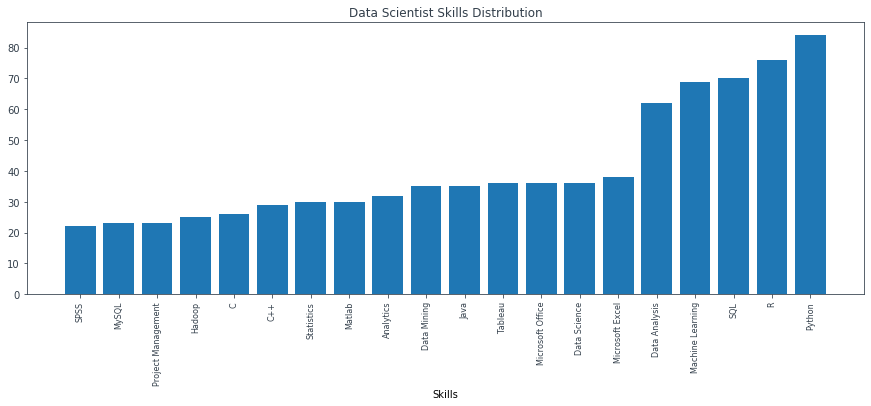

In [27]:
plot_bar_skills()

Data Scientist Licenses and Certificates Stats: 
------------------------------------------------
100th percentile count:  13
75th percentile count:  5.0
50th percentile count:  1.0
25th percentile count:  1.0
Mean count:  3


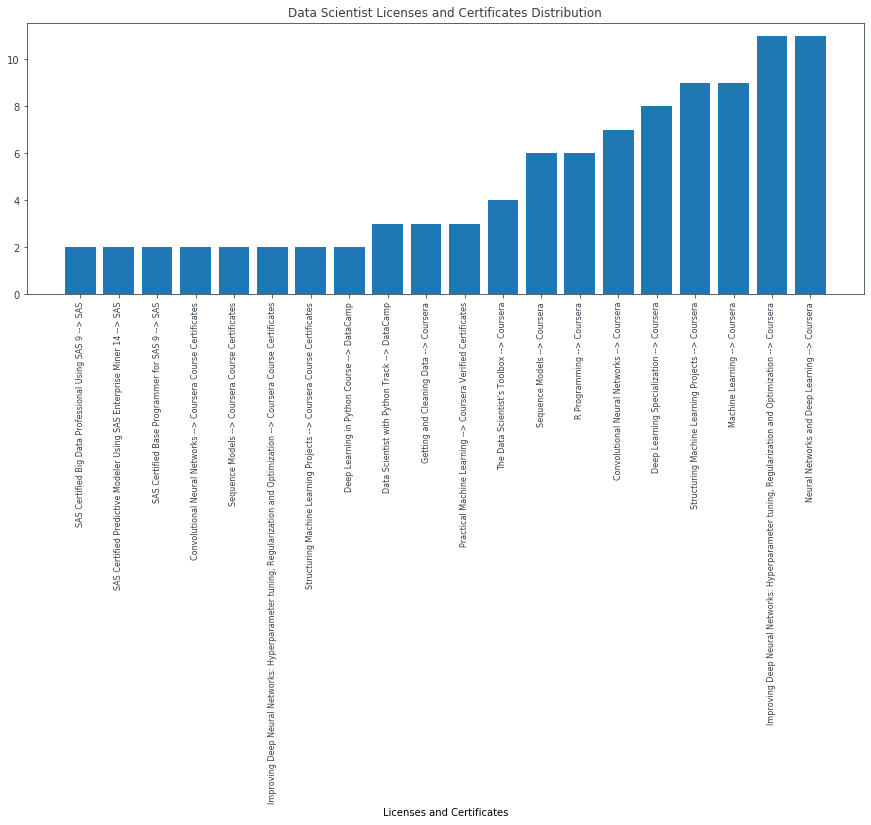

In [35]:
data_scientist_landc = []
data_scientist_landc_length = []

for i in range(len(all_experiences)):
    
    try:
        if all_experiences[i][0]['title'] == "Data Scientist":
            data_scientist_landc_length.append(len(all_landc[i]))
            for landcs in all_landc[i]:
                data_scientist_landc.append(landcs['name']+" --> "+landcs['provider'])
            
    except:
        pass
    

data_scientist_landcs_count = Counter(data_scientist_landc)
data_scientist_landcs_count_sorted = sorted(data_scientist_landcs_count.items(), key=lambda kv: kv[1])


ds_landcs = []
ds_landcs_count = []
for item in data_scientist_landcs_count_sorted[-20:]:
    ds_landcs.append(item[0])
    ds_landcs_count.append(item[1])

    
print("Data Scientist Licenses and Certificates Stats: ")
print("------------------------------------------------")
print("100th percentile count: ", max(data_scientist_landc_length))
print("75th percentile count: ", np.percentile(np.array(data_scientist_landc_length), 75))
print("50th percentile count: ", np.percentile(np.array(data_scientist_landc_length), 50))
print("25th percentile count: ", np.percentile(np.array(data_scientist_landc_length), 25))
print("Mean count: ", int(statistics.mean(data_scientist_landc_length)))

def plot_bar_landcs():
    # this is for plotting purpose
    index = np.arange(len(ds_landcs))
    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    plt.rcParams['figure.figsize'] = 15, 5
    plt.bar(index, ds_landcs_count)
    plt.xlabel('Licenses and Certificates', fontsize=10)
    plt.xticks(index, ds_landcs, fontsize=8, rotation=90)
    plt.title('Data Scientist Licenses and Certificates Distribution')
    plt.show()
    
    
plot_bar_landcs()

In [128]:
description = ""

for experiences in all_experiences:
    try:
        if experiences[0]['title'] == "Data Scientist":
            if experiences[0]['description'] != "Nil":
                description += experiences[0]['description']
                description += " "
    except:
        pass

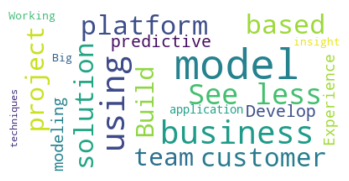

In [129]:
# Display the generated image:
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=20, background_color="white").generate(description)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Senior Data Scientist

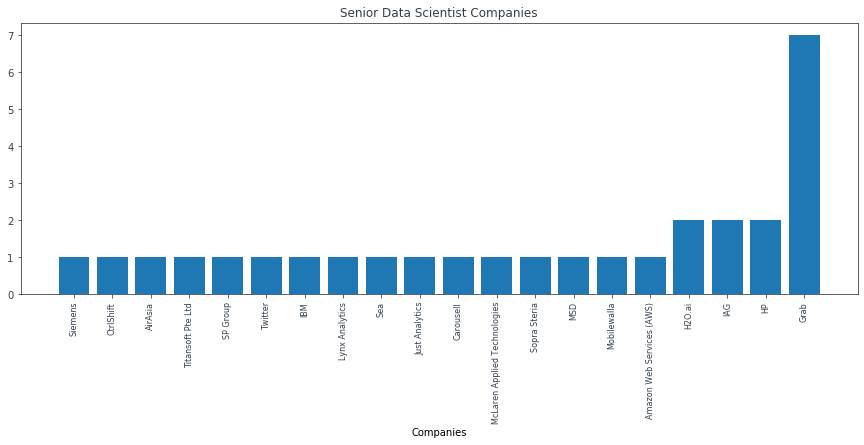

In [68]:
senior_data_scientist_company = []

for i in range(len(all_experiences)):
    
    try:
        if all_experiences[i][0]['title'] == "Senior Data Scientist":
            senior_data_scientist_company.append(all_experiences[i][0]['company'])
            
    except:
        pass
    
    
senior_data_scientist_company_count = Counter(senior_data_scientist_company)
senior_data_scientist_company_count_sorted = sorted(senior_data_scientist_company_count.items(), key=lambda kv: kv[1])


sds_company = []
sds_company_count = []
for item in senior_data_scientist_company_count_sorted[-20:]:
    sds_company.append(item[0])
    sds_company_count.append(item[1])
    
    
def plot_bar_companies():
    # this is for plotting purpose
    index = np.arange(len(sds_company))
    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    plt.rcParams['figure.figsize'] = 15, 5
    plt.bar(index, sds_company_count)
    plt.xlabel('Companies', fontsize=10)
    plt.xticks(index, sds_company, fontsize=8, rotation=90)
    plt.title('Senior Data Scientist Companies')
    plt.show()
    
    
plot_bar_companies()

In [18]:
senior_data_scientist_school = []
senior_data_scientist_course_type = []
senior_data_scientist_course = []

for i in range(len(all_experiences)):
    
    try:
        if all_experiences[i][0]['title'] == "Senior Data Scientist":
            senior_data_scientist_school.append(all_educations[i][0]['school'])
            senior_data_scientist_course_type.append(all_educations[i][0]['type'])
            senior_data_scientist_course.append(all_educations[i][0]['course'])
            
    except:
        pass

In [19]:
senior_data_scientist_course_type_phd_count = 0
senior_data_scientist_course_type_masters_count = 0
senior_data_scientist_course_type_bachelor_count = 0
senior_data_scientist_course_type_others_count = 0

for course_type in senior_data_scientist_course_type:
    
    #MASTERS
    if "Master" in course_type or "MPhil" in course_type or "MTech" in course_type or "M.Tech" in course_type or "M.Phil." in course_type or "MA" in course_type or "MS" in course_type or "M.S." in course_type:
        senior_data_scientist_course_type_masters_count += 1
    #PHD
    elif "Doctor" in course_type or "PhD" in course_type or "Ph.D." in course_type or "Ph.D" in course_type:
        senior_data_scientist_course_type_phd_count += 1
    #BACHELOR
    elif "Bachelor" in course_type or "BSE" in course_type or "B.Tech" in course_type or "BA" in course_type in course_type:
        senior_data_scientist_course_type_bachelor_count += 1
    #OTHERS
    else:
        senior_data_scientist_course_type_others_count += 1

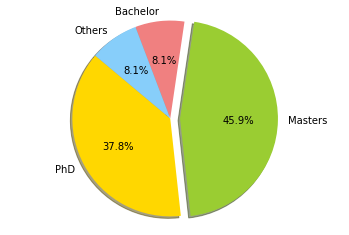

In [20]:
# Data to plot
labels = 'PhD', 'Masters', 'Bachelor', 'Others'
sizes = [senior_data_scientist_course_type_phd_count, senior_data_scientist_course_type_masters_count, senior_data_scientist_course_type_bachelor_count, senior_data_scientist_course_type_others_count]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode_phd = 0
explode_masters = 0
explode_bachelor = 0
explode_others = 0
index = sizes.index(max(sizes))
if index == 0:
    explode_phd = 0.1
elif index == 1:
    explode_masters = 0.1
elif index == 2:
    explode_bachelor = 0.1
else:
    explode_others = 0.1
explode = (explode_phd, explode_masters, explode_bachelor, explode_others)  # explode max slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [84]:
total_duration = []

for experiences in all_experiences:
    try:
        if experiences[0]['title'] == "Senior Data Scientist":
            duration = 0
            try:
                for experience in experiences[1:]:
                    length = experience['duration_length']
                    length = length.split(" ")

                    months = 0
                    years = 0

                    if len(length) == 2:
                        months = length[0]
                    else:
                        years = int(length[0])
                        months = int(length[2])
                        
                    temp_duration = (years*12)+months
                    duration += temp_duration
            except:
                pass

            total_duration.append(duration)
    except:
        pass

In [85]:
print("Max years to be Senior Data Scientist: ", max(total_duration), "months")
print("Avg years to be Senior Data Scientist: ", sum(total_duration)/len(total_duration), "months")
print("Median years to be Senior Data Scientist: ", statistics.median(total_duration), "months")

Max years to be Senior Data Scientist:  128 months
Avg years to be Senior Data Scientist:  26.2972972972973 months
Median years to be Senior Data Scientist:  16 months


In [10]:
senior_data_scientist_skills = []
senior_data_scientist_count = 0
max_skills_count = 0

for i in range(len(all_experiences)):
    
    try:
        if all_experiences[i][0]['title'] == "Senior Data Scientist":
            senior_data_scientist_count += 1
            senior_data_scientist_skills.extend(all_skills[i])
            
            if len(all_skills[i]) > max_skills_count:
                max_skills_count = len(all_skills[i])
            
    except:
        pass
    
print("Senior Data Scientist Skills Count\n--------------------")
print("Max skills count: ", max_skills_count)
print("Avg skiils count: ", round(len(senior_data_scientist_skills)/senior_data_scientist_count))

Senior Data Scientist Skills Count
--------------------
Max skills count:  50
Avg skiils count:  25


In [34]:
senior_data_scientist_skills_count = Counter(senior_data_scientist_skills)
senior_data_scientist_skills_count_sorted = sorted(senior_data_scientist_skills_count.items(), key=lambda kv: kv[1])

In [35]:
sds_skills = []
sds_skills_count = []
for item in senior_data_scientist_skills_count_sorted[-20:]:
    sds_skills.append(item[0])
    sds_skills_count.append(item[1])

In [55]:
def plot_bar_skills():
    # this is for plotting purpose
    index = np.arange(len(sds_skills))
    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    plt.rcParams['figure.figsize'] = 15, 5
    plt.bar(index, sds_skills_count)
    plt.xlabel('Skills', fontsize=10)
    plt.xticks(index, sds_skills, fontsize=8, rotation=90)
    plt.title('Senior Data Scientist Skills Distribution')
    plt.show()

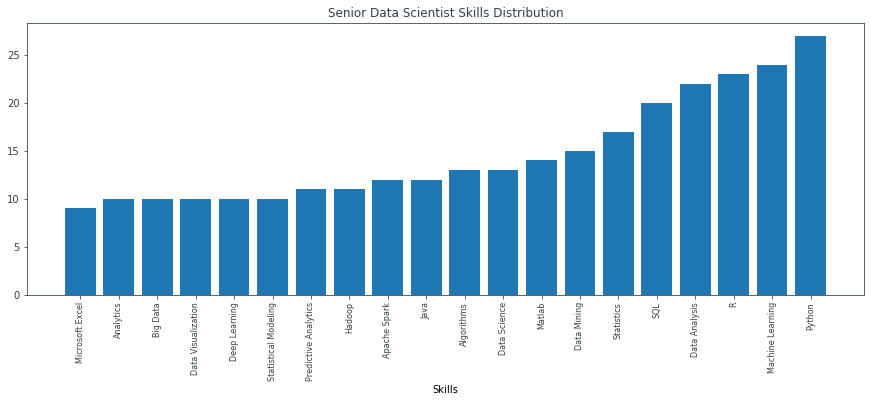

In [56]:
plot_bar_skills()

Senior Data Scientist Licenses and Certificates Stats: 
------------------------------------------------
100th percentile count:  13
75th percentile count:  6.0
50th percentile count:  2.0
25th percentile count:  1.0
Mean count:  4


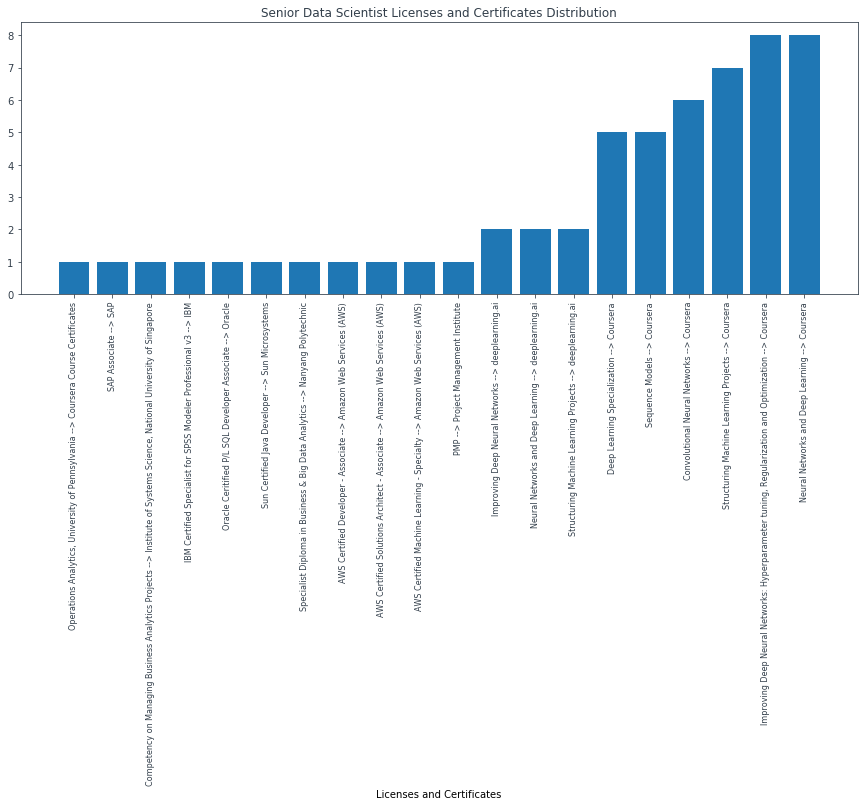

In [36]:
senior_data_scientist_landc = []
senior_data_scientist_landc_length = []

for i in range(len(all_experiences)):
    
    try:
        if all_experiences[i][0]['title'] == "Senior Data Scientist":
            senior_data_scientist_landc_length.append(len(all_landc[i]))
            for landcs in all_landc[i]:
                senior_data_scientist_landc.append(landcs['name']+" --> "+landcs['provider'])
            
    except:
        pass
    

senior_data_scientist_landcs_count = Counter(senior_data_scientist_landc)
senior_data_scientist_landcs_count_sorted = sorted(senior_data_scientist_landcs_count.items(), key=lambda kv: kv[1])


sds_landcs = []
sds_landcs_count = []
for item in senior_data_scientist_landcs_count_sorted[-20:]:
    sds_landcs.append(item[0])
    sds_landcs_count.append(item[1])
    
print("Senior Data Scientist Licenses and Certificates Stats: ")
print("------------------------------------------------")
print("100th percentile count: ", max(senior_data_scientist_landc_length))
print("75th percentile count: ", np.percentile(np.array(senior_data_scientist_landc_length), 75))
print("50th percentile count: ", np.percentile(np.array(senior_data_scientist_landc_length), 50))
print("25th percentile count: ", np.percentile(np.array(senior_data_scientist_landc_length), 25))
print("Mean count: ", int(statistics.mean(senior_data_scientist_landc_length)))

def plot_bar_landcs():
    # this is for plotting purpose
    index = np.arange(len(sds_landcs))
    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    plt.rcParams['figure.figsize'] = 15, 5
    plt.bar(index, sds_landcs_count)
    plt.xlabel('Licenses and Certificates', fontsize=10)
    plt.xticks(index, sds_landcs, fontsize=8, rotation=90)
    plt.title('Senior Data Scientist Licenses and Certificates Distribution')
    plt.show()
    
    
plot_bar_landcs()

In [126]:
description = ""

for experiences in all_experiences:
    try:
        if experiences[0]['title'] == "Senior Data Scientist":
            if experiences[0]['description'] != "Nil":
                description += experiences[0]['description']
                description += " "
    except:
        pass

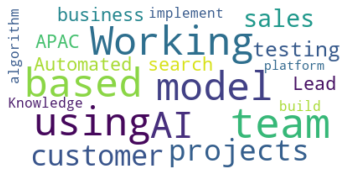

In [127]:
# Display the generated image:
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=20, background_color="white").generate(description)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Data Analyst

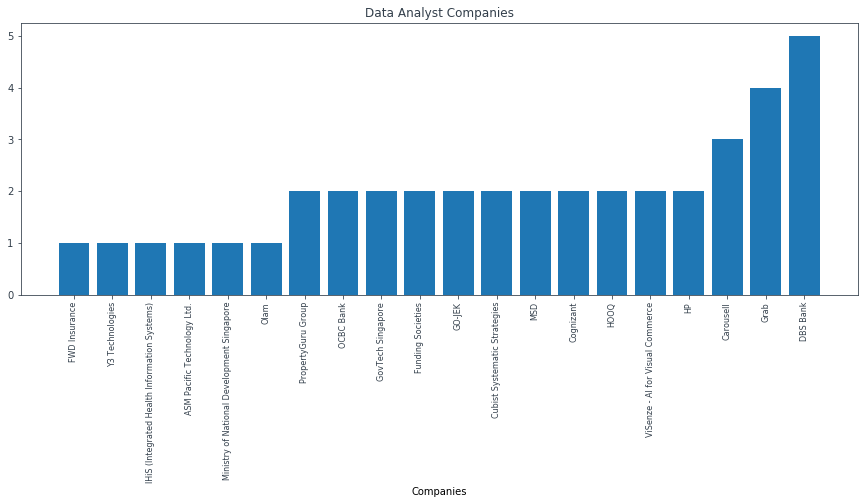

In [69]:
data_analyst_company = []

for i in range(len(all_experiences)):
    
    try:
        if all_experiences[i][0]['title'] == "Data Analyst":
            data_analyst_company.append(all_experiences[i][0]['company'])
            
    except:
        pass
    
    
data_analyst_company_count = Counter(data_analyst_company)
data_analyst_company_count_sorted = sorted(data_analyst_company_count.items(), key=lambda kv: kv[1])


da_company = []
da_company_count = []
for item in data_analyst_company_count_sorted[-20:]:
    da_company.append(item[0])
    da_company_count.append(item[1])
    
    
def plot_bar_companies():
    # this is for plotting purpose
    index = np.arange(len(da_company))
    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    plt.rcParams['figure.figsize'] = 15, 5
    plt.bar(index, da_company_count)
    plt.xlabel('Companies', fontsize=10)
    plt.xticks(index, da_company, fontsize=8, rotation=90)
    plt.title('Data Analyst Companies')
    plt.show()
    
    
plot_bar_companies()

In [22]:
data_analyst_school = []
data_analyst_course_type = []
data_analyst_course = []

for i in range(len(all_experiences)):
    
    try:
        if all_experiences[i][0]['title'] == "Data Analyst":
            data_analyst_school.append(all_educations[i][0]['school'])
            data_analyst_course_type.append(all_educations[i][0]['type'])
            data_analyst_course.append(all_educations[i][0]['course'])
            
    except:
        pass

In [23]:
data_analyst_course_type_phd_count = 0
data_analyst_course_type_masters_count = 0
data_analyst_course_type_bachelor_count = 0
data_analyst_course_type_others_count = 0

for course_type in data_analyst_course_type:
    
    #MASTERS
    if "Master" in course_type or "MPhil" in course_type or "MTech" in course_type or "M.Tech" in course_type or "M.Phil." in course_type or "MA" in course_type or "MS" in course_type or "M.S." in course_type:
        data_analyst_course_type_masters_count += 1
    #PHD
    elif "Doctor" in course_type or "PhD" in course_type or "Ph.D." in course_type or "Ph.D" in course_type:
        data_analyst_course_type_phd_count += 1
    #BACHELOR
    elif "Bachelor" in course_type or "BSE" in course_type or "B.Tech" in course_type or "BA" in course_type in course_type:
        data_analyst_course_type_bachelor_count += 1
    #OTHERS
    else:
        data_analyst_course_type_others_count += 1

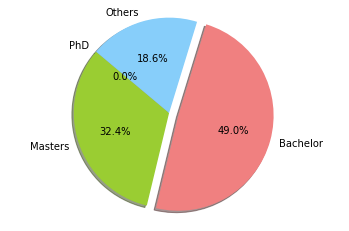

In [24]:
# Data to plot
labels = 'PhD', 'Masters', 'Bachelor', 'Others'
sizes = [data_analyst_course_type_phd_count, data_analyst_course_type_masters_count, data_analyst_course_type_bachelor_count, data_analyst_course_type_others_count]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode_phd = 0
explode_masters = 0
explode_bachelor = 0
explode_others = 0
index = sizes.index(max(sizes))
if index == 0:
    explode_phd = 0.1
elif index == 1:
    explode_masters = 0.1
elif index == 2:
    explode_bachelor = 0.1
else:
    explode_others = 0.1
explode = (explode_phd, explode_masters, explode_bachelor, explode_others)  # explode max slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [87]:
total_duration = []

for experiences in all_experiences:
    try:
        if experiences[0]['title'] == "Data Analyst":
            duration = 0
            try:
                for experience in experiences[1:]:
                    length = experience['duration_length']
                    length = length.split(" ")

                    months = 0
                    years = 0

                    if len(length) == 2:
                        months = length[0]
                    else:
                        years = int(length[0])
                        months = int(length[2])
                        
                    temp_duration = (years*12)+months
                    duration += temp_duration
            except:
                pass

            total_duration.append(duration)
    except:
        pass

In [88]:
print("Max years to be Data Analyst: ", max(total_duration), "months")
print("Avg years to be Data Analyst: ", sum(total_duration)/len(total_duration), "months")
print("Median years to be Data Analyst: ", statistics.median(total_duration), "months")

Max years to be Data Analyst:  166 months
Avg years to be Data Analyst:  17.794117647058822 months
Median years to be Data Analyst:  0.0 months


In [11]:
data_analyst_skills = []
data_analyst_count = 0
max_skills_count = 0

for i in range(len(all_experiences)):
    
    try:
        if all_experiences[i][0]['title'] == "Data Analyst":
            data_analyst_count += 1
            data_analyst_skills.extend(all_skills[i])
            
            if len(all_skills[i]) > max_skills_count:
                max_skills_count = len(all_skills[i])
            
    except:
        pass
    
print("Data Analyst Skills Count\n--------------------")
print("Max skills count: ", max_skills_count)
print("Avg skiils count: ", round(len(data_analyst_skills)/data_analyst_count))

Data Analyst Skills Count
--------------------
Max skills count:  49
Avg skiils count:  15


In [29]:
data_analyst_skills_count = Counter(data_analyst_skills)
data_analyst_skills_count_sorted = sorted(data_analyst_skills_count.items(), key=lambda kv: kv[1])

In [30]:
da_skills = []
da_skills_count = []
for item in data_analyst_skills_count_sorted[-20:]:
    da_skills.append(item[0])
    da_skills_count.append(item[1])

In [31]:
def plot_bar_skills():
    # this is for plotting purpose
    index = np.arange(len(da_skills))
    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    plt.rcParams['figure.figsize'] = 15, 5
    plt.bar(index, da_skills_count)
    plt.xlabel('Skills', fontsize=10)
    plt.xticks(index, da_skills, fontsize=8, rotation=90)
    plt.title('Data Analyst Skills Distribution')
    plt.show()

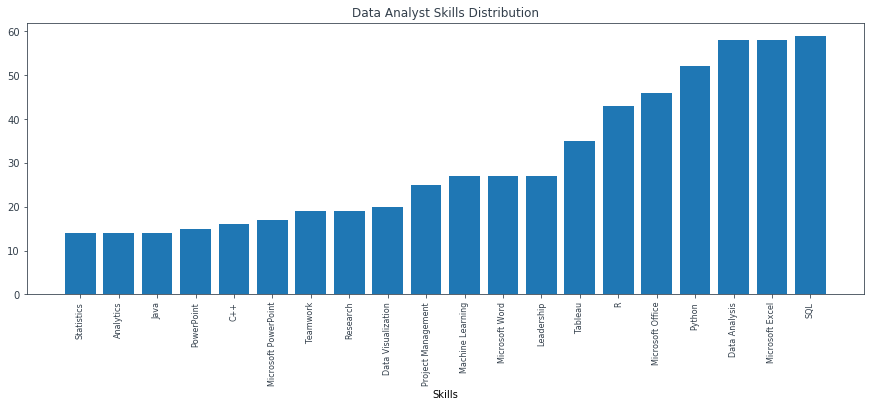

In [32]:
plot_bar_skills()

Data Analyst Licenses and Certificates Stats: 
------------------------------------------------
100th percentile count:  13
75th percentile count:  3.0
50th percentile count:  1.0
25th percentile count:  1.0
Mean count:  2


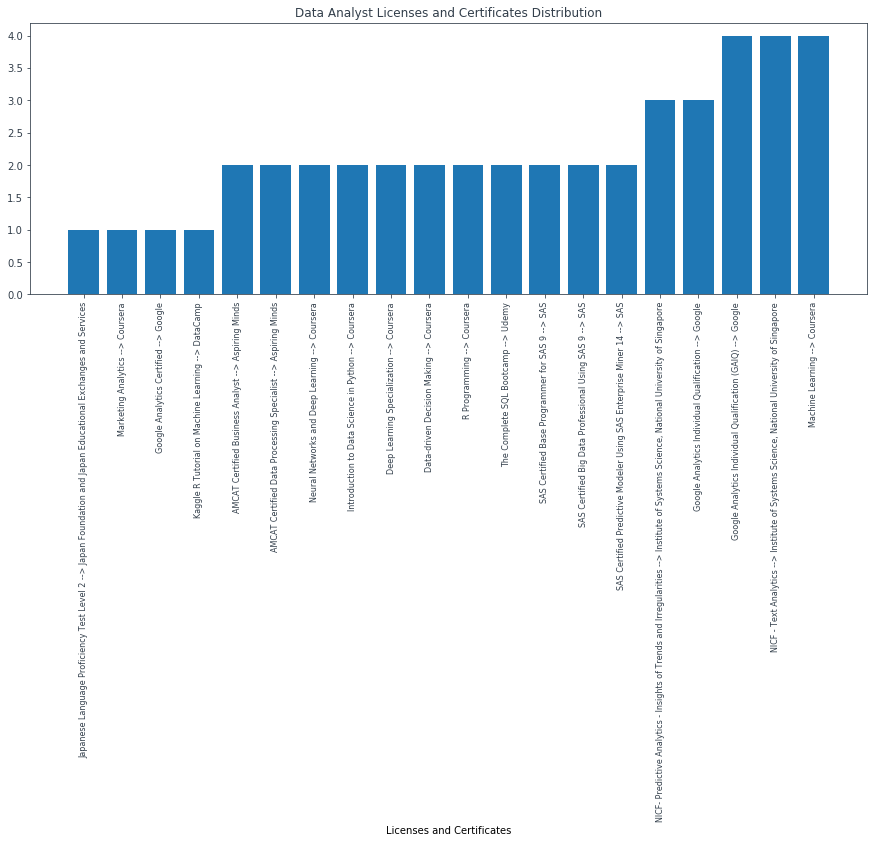

In [37]:
data_analyst_landc = []
data_analyst_landc_length = []

for i in range(len(all_experiences)):
    
    try:
        if all_experiences[i][0]['title'] == "Data Analyst":
            data_analyst_landc_length.append(len(all_landc[i]))
            for landcs in all_landc[i]:
                data_analyst_landc.append(landcs['name']+" --> "+landcs['provider'])
            
    except:
        pass
    

data_analyst_landcs_count = Counter(data_analyst_landc)
data_analyst_landcs_count_sorted = sorted(data_analyst_landcs_count.items(), key=lambda kv: kv[1])


da_landcs = []
da_landcs_count = []
for item in data_analyst_landcs_count_sorted[-20:]:
    da_landcs.append(item[0])
    da_landcs_count.append(item[1])
    
print("Data Analyst Licenses and Certificates Stats: ")
print("------------------------------------------------")
print("100th percentile count: ", max(data_analyst_landc_length))
print("75th percentile count: ", np.percentile(np.array(data_analyst_landc_length), 75))
print("50th percentile count: ", np.percentile(np.array(data_analyst_landc_length), 50))
print("25th percentile count: ", np.percentile(np.array(data_analyst_landc_length), 25))
print("Mean count: ", int(statistics.mean(data_analyst_landc_length)))

def plot_bar_landcs():
    # this is for plotting purpose
    index = np.arange(len(da_landcs))
    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    plt.rcParams['figure.figsize'] = 15, 5
    plt.bar(index, da_landcs_count)
    plt.xlabel('Licenses and Certificates', fontsize=10)
    plt.xticks(index, da_landcs, fontsize=8, rotation=90)
    plt.title('Data Analyst Licenses and Certificates Distribution')
    plt.show()
    
    
plot_bar_landcs()

In [124]:
description = ""

for experiences in all_experiences:
    try:
        if experiences[0]['title'] == "Data Analyst":
            if experiences[0]['description'] != "Nil":
                description += experiences[0]['description']
                description += " "
    except:
        pass

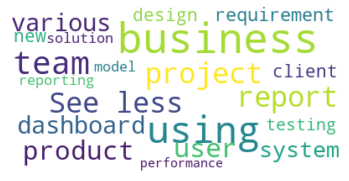

In [125]:
# Display the generated image:
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=20, background_color="white").generate(description)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Senior Data Analyst

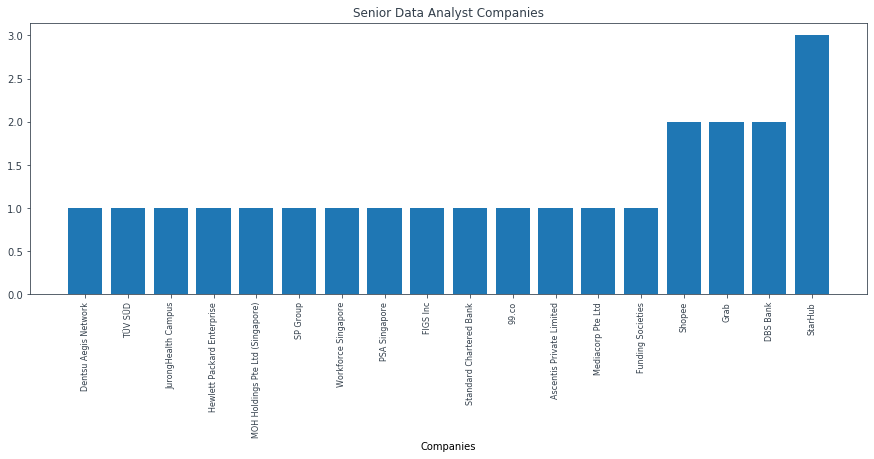

In [70]:
senior_data_analyst_company = []

for i in range(len(all_experiences)):
    
    try:
        if all_experiences[i][0]['title'] == "Senior Data Analyst":
            senior_data_analyst_company.append(all_experiences[i][0]['company'])
            
    except:
        pass
    
    
senior_data_analyst_company_count = Counter(senior_data_analyst_company)
senior_data_analyst_company_count_sorted = sorted(senior_data_analyst_company_count.items(), key=lambda kv: kv[1])


sda_company = []
sda_company_count = []
for item in senior_data_analyst_company_count_sorted[-20:]:
    sda_company.append(item[0])
    sda_company_count.append(item[1])
    
    
def plot_bar_companies():
    # this is for plotting purpose
    index = np.arange(len(sda_company))
    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    plt.rcParams['figure.figsize'] = 15, 5
    plt.bar(index, sda_company_count)
    plt.xlabel('Companies', fontsize=10)
    plt.xticks(index, sda_company, fontsize=8, rotation=90)
    plt.title('Senior Data Analyst Companies')
    plt.show()
    
    
plot_bar_companies()

In [27]:
senior_data_analyst_school = []
senior_data_analyst_course_type = []
senior_data_analyst_course = []

for i in range(len(all_experiences)):
    
    try:
        if all_experiences[i][0]['title'] == "Senior Data Analyst":
            senior_data_analyst_school.append(all_educations[i][0]['school'])
            senior_data_analyst_course_type.append(all_educations[i][0]['type'])
            senior_data_analyst_course.append(all_educations[i][0]['course'])
            
    except:
        pass

In [31]:
senior_data_analyst_course_type_phd_count = 0
senior_data_analyst_course_type_masters_count = 0
senior_data_analyst_course_type_bachelor_count = 0
senior_data_analyst_course_type_others_count = 0

for course_type in senior_data_analyst_course_type:
    
    #MASTERS
    if "Master" in course_type or "MPhil" in course_type or "MTech" in course_type or "M.Tech" in course_type or "M.Phil." in course_type or "MA" in course_type or "MS" in course_type or "M.S." in course_type:
        senior_data_analyst_course_type_masters_count += 1
    #PHD
    elif "Doctor" in course_type or "PhD" in course_type or "Ph.D." in course_type or "Ph.D" in course_type:
        senior_data_analyst_course_type_phd_count += 1
    #BACHELOR
    elif "Bachelor" in course_type or "BSE" in course_type or "B.Tech" in course_type or "BA" in course_type in course_type:
        senior_data_analyst_course_type_bachelor_count += 1
    #OTHERS
    else:
        senior_data_analyst_course_type_others_count += 1

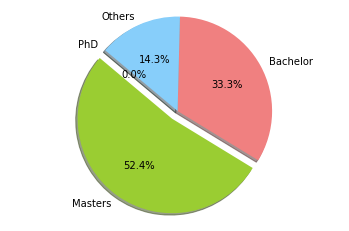

In [32]:
# Data to plot
labels = 'PhD', 'Masters', 'Bachelor', 'Others'
sizes = [senior_data_analyst_course_type_phd_count, senior_data_analyst_course_type_masters_count, senior_data_analyst_course_type_bachelor_count, senior_data_analyst_course_type_others_count]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode_phd = 0
explode_masters = 0
explode_bachelor = 0
explode_others = 0
index = sizes.index(max(sizes))
if index == 0:
    explode_phd = 0.1
elif index == 1:
    explode_masters = 0.1
elif index == 2:
    explode_bachelor = 0.1
else:
    explode_others = 0.1
explode = (explode_phd, explode_masters, explode_bachelor, explode_others)  # explode max slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [89]:
total_duration = []

for experiences in all_experiences:
    try:
        if experiences[0]['title'] == "Senior Data Analyst":
            duration = 0
            try:
                for experience in experiences[1:]:
                    length = experience['duration_length']
                    length = length.split(" ")

                    months = 0
                    years = 0

                    if len(length) == 2:
                        months = length[0]
                    else:
                        years = int(length[0])
                        months = int(length[2])
                        
                    temp_duration = (years*12)+months
                    duration += temp_duration
            except:
                pass

            total_duration.append(duration)
    except:
        pass

In [90]:
print("Max years to be Senior Data Analyst: ", max(total_duration), "months")
print("Avg years to be Senior Data Analyst: ", sum(total_duration)/len(total_duration), "months")
print("Median years to be Senior Data Analyst: ", statistics.median(total_duration), "months")

Max years to be Senior Data Analyst:  162 months
Avg years to be Senior Data Analyst:  39.608695652173914 months
Median years to be Senior Data Analyst:  27 months


In [12]:
senior_data_analyst_skills = []
senior_data_analyst_count = 0
max_skills_count = 0

for i in range(len(all_experiences)):
    
    try:
        if all_experiences[i][0]['title'] == "Senior Data Analyst":
            senior_data_analyst_count += 1
            senior_data_analyst_skills.extend(all_skills[i])
            
            if len(all_skills[i]) > max_skills_count:
                max_skills_count = len(all_skills[i])
            
    except:
        pass
    
print("Senior Data Analyst Skills Count\n--------------------")
print("Max skills count: ", max_skills_count)
print("Avg skiils count: ", round(len(senior_data_analyst_skills)/senior_data_analyst_count))

Senior Data Analyst Skills Count
--------------------
Max skills count:  47
Avg skiils count:  20


In [39]:
senior_data_analyst_skills_count = Counter(senior_data_analyst_skills)
senior_data_analyst_skills_count_sorted = sorted(senior_data_analyst_skills_count.items(), key=lambda kv: kv[1])

In [40]:
sda_skills = []
sda_skills_count = []
for item in senior_data_analyst_skills_count_sorted[-20:]:
    sda_skills.append(item[0])
    sda_skills_count.append(item[1])

In [57]:
def plot_bar_skills():
    # this is for plotting purpose
    index = np.arange(len(sda_skills))
    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    plt.rcParams['figure.figsize'] = 15, 5
    plt.bar(index, sda_skills_count)
    plt.xlabel('Skills', fontsize=10)
    plt.xticks(index, sda_skills, fontsize=8, rotation=90)
    plt.title('Senior Data Analyst Skills Distribution')
    plt.show()

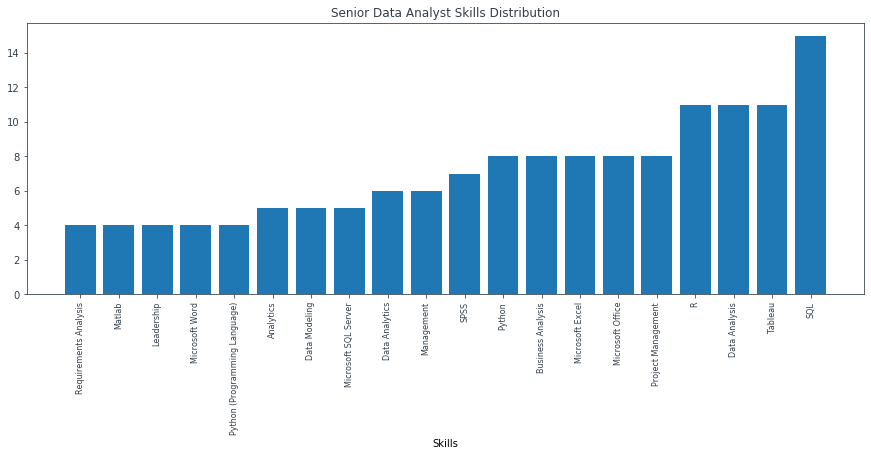

In [58]:
plot_bar_skills()

Senior Data Analyst Licenses and Certificates Stats: 
------------------------------------------------
100th percentile count:  12
75th percentile count:  3.5
50th percentile count:  2.0
25th percentile count:  1.0
Mean count:  2


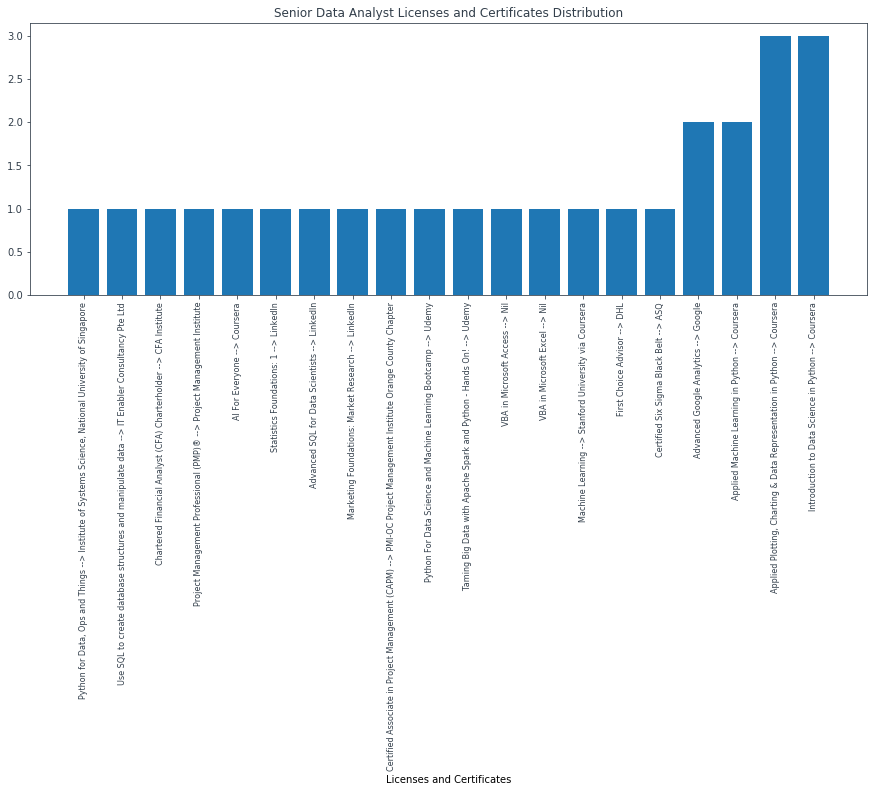

In [38]:
senior_data_analyst_landc = []
senior_data_analyst_landc_length = []

for i in range(len(all_experiences)):
    
    try:
        if all_experiences[i][0]['title'] == "Senior Data Analyst":
            senior_data_analyst_landc_length.append(len(all_landc[i]))
            for landcs in all_landc[i]:
                senior_data_analyst_landc.append(landcs['name']+" --> "+landcs['provider'])
            
    except:
        pass
    

senior_data_analyst_landcs_count = Counter(senior_data_analyst_landc)
senior_data_analyst_landcs_count_sorted = sorted(senior_data_analyst_landcs_count.items(), key=lambda kv: kv[1])


sda_landcs = []
sda_landcs_count = []
for item in senior_data_analyst_landcs_count_sorted[-20:]:
    sda_landcs.append(item[0])
    sda_landcs_count.append(item[1])
    
print("Senior Data Analyst Licenses and Certificates Stats: ")
print("------------------------------------------------")
print("100th percentile count: ", max(senior_data_analyst_landc_length))
print("75th percentile count: ", np.percentile(np.array(senior_data_analyst_landc_length), 75))
print("50th percentile count: ", np.percentile(np.array(senior_data_analyst_landc_length), 50))
print("25th percentile count: ", np.percentile(np.array(senior_data_analyst_landc_length), 25))
print("Mean count: ", int(statistics.mean(senior_data_analyst_landc_length)))
    
def plot_bar_landcs():
    # this is for plotting purpose
    index = np.arange(len(sda_landcs))
    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'
    plt.rcParams['figure.figsize'] = 15, 5
    plt.bar(index, sda_landcs_count)
    plt.xlabel('Licenses and Certificates', fontsize=10)
    plt.xticks(index, sda_landcs, fontsize=8, rotation=90)
    plt.title('Senior Data Analyst Licenses and Certificates Distribution')
    plt.show()
    
    
plot_bar_landcs()

In [120]:
description = ""

for experiences in all_experiences:
    try:
        if experiences[0]['title'] == "Senior Data Analyst":
            if experiences[0]['description'] != "Nil":
                description += experiences[0]['description']
                description += " "
    except:
        pass

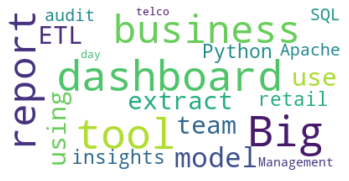

In [122]:
# Display the generated image:
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=20, background_color="white").generate(description)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Profile Scorer [35 points total]

#### Using all the insights, we can create a simple profile scorer.

#### 1) Number of Connections [5 points]
- 500+ = 5 points
- 400-499 = 4 points
- 300-399 = 3 points
- 200-299 = 2 points
- 100-199 = 1 point
- 0-99 = 0 point

#### 2) Length of About Section [3 points]
- 150 words and above = 3 points
- 75-149 words = 2 points
- 35-74 words = 1 point
- 0-34 words = 0 point

#### 3) Years of Experience [5 points]
- Above 120 months (10 years) = 5 points
- Up to 120 months (10 years) = 4 points
- Up to 84 months (7 years) = 3 points
- Up to 60 months (5 years) = 2 points 
- Up to 24 months (2 years) = 1 points
- 0 month = 0 points

#### 4) Recent Position [5 points]
- Lead/Chief xxx = 5 points
- Senior xxx = 4 points
- Data Scientist/Analyst = 3 points
- xxx Intern = 1 point

#### 5) Education Level [4 points]
- PhD = 4 points
- Masters = 3 points
- Bachelor = 2 points
- Others = 1 point

#### 6) Number of Skills [5 points]
- 50 = 5 points
- 40-49 = 4 points
- 30-39 = 3 points
- 20-29 = 2 points
- 10-19 = 1 point
- 0-9 = 0 point


#### 7) Skills Checklist [5 points max]
- Python, SQL, Data Analysis, R, Machine Learning, Microsoft Excel, Tableau, Analytics, Data Mining, Data Science, Data Visualization = 1 point each

#### 8) Number of Licenses and Certificates [3 points]
- 6 and above = 3 points
- 3-5 = 2 points
- 1-2 = 1 point
- 0 = 0 point

In [208]:
def profile_scorer(profile):
    total_score = 0
    
    no_of_connection = profile['no_of_connections']
    about = profile['about']
    experiences = profile['experiences']
    educations = profile['educations']
    landcs = profile['licenses_and_certificates']
    skills = profile['skills']
    
    # CONNECTIONS
    noc = no_of_connection.replace(' connections', '')
    noc = noc.replace(' connection', '')
    noc = noc.replace('500+', str(501))
    noc = int(noc)
    print("Number of connections: ", noc)
    if noc >= 500:
        total_score += 5
        print("5/5")
    elif noc >= 400 and noc < 500:
        total_score += 4
        print("4/5")
    elif noc >= 300 and noc < 400:
        total_score += 3
        print("3/5")
    elif noc >= 200 and noc < 300:
        total_score += 2
        print("2/5")
    elif noc >= 100 and noc < 200:
        total_score += 1
        print("1/5")
    else:
        print("0/5")
    #================ 
    
    # ABOUT SECTION
    about_tokens = about.split(" ")
    about_length = len(about_tokens)
    print("About length: ", about_length)
    if about_length >= 150:
        total_score += 3
        print("3/3")
    elif about_length >= 75 and about_length < 150:
        total_score += 2
        print("2/3")
    elif about_length >= 35 and about_length < 75:
        total_score += 1
        print("1/3")
    else:
        print("0/3")
    #================ 
    
    # EXPERIENCES
    total_duration = 0
    for profile in experiences:
        durations = profile['duration_length']
        duration = durations.split(" ")
        months = 0
        years = 0
        if len(duration) == 2:
            months = int(duration[0])
        else:
            years = int(duration[0])
            months = int(duration[2])
        temp_duration = (years*12)+months
        total_duration += temp_duration
    print("Total work experience: ", total_duration, " months")
    if total_duration >= 120:
        total_score += 5
        print("5/5")
    elif total_duration >= 84 and total_duration < 120 :
        total_score += 4
        print("4/5")
    elif total_duration >= 60 and total_duration < 84:
        total_score += 3
        print("3/5")
    elif total_duration >= 24 and total_duration < 60:
        total_score += 2
        print("2/5")
    else:
        total_score += 1
        print("1/5")
    #================ 
    
    # RECENT POSITION
    recent_position = experiences[0]['title']
    print("Recent position: ", recent_position)
    recent_position = recent_position.lower()
    if "chief" in recent_position or "lead" in recent_position:
        total_score += 5
        print("5/5")
    elif "senior" in recent_position:
        total_score += 4
        print("4/5")
    elif "intern" in recent_position:
        total_score += 1
        print("1/5")
    else:
        total_score += 3
        print("3/5")
    #================ 
    
    # EDUCATION LEVEL
    course_type = educations[0]['type']
    print("Education level: ", course_type)
    if "Master" in course_type or "MPhil" in course_type or "MTech" in course_type or "M.Tech" in course_type or "M.Phil." in course_type or "MA" in course_type or "MS" in course_type or "M.S." in course_type:
        total_score += 3
        print("3/4")
    elif "Doctor" in course_type or "PhD" in course_type or "Ph.D." in course_type or "Ph.D" in course_type:
        total_score += 4
        print("4/4")
    elif "Bachelor" in course_type or "BSE" in course_type or "B.Tech" in course_type or "BA" in course_type in course_type:
        total_score += 2
        print("2/4")
    else:
        total_score += 1
        print("1/4")
    #================ 
    
    # NUMBER OF SKILLS
    no_skills = int(len(skills))
    print("Number of skills: ", no_skills)
    if no_skills >= 50:
        total_score += 5
        print("5/5")
    elif no_skills >= 40 and no_skills < 50:
        total_score += 4
        print("4/5")
    elif no_skills >= 30 and no_skills < 40:
        total_score += 3
        print("3/5")
    elif no_skills >= 20 and no_skills < 30:
        total_score += 2
        print("2/5")
    elif no_skills >= 10 and no_skills < 20:
        total_score += 1
        print("1/5")
    else:
        print("0/5")
    #================ 
    
    # SKILLS CHECKLIST
    skills_list = ['Python', 'SQL', 'Data Analysis', 'R', 'Machine Learning', 'Microsoft Excel', 'Tableau', 'Analytics', 'Data Mining', 'Data Science', 'Data Visualization']
    skills_have = []
    for skill in skills_list:
        if skill in skills:
            skills_have.append(skill)
    print("Skills checklist: ", skills_have)   
    if len(skills_have) >= 5:
        total_score += 5
        print("5/5")
    else:
        total_score += len(skills_have)
        print(len(skills_have),"/5")
    #================ 
    
    # L AND C COUNT
    landcs_count = len(landcs)
    print("Number of licenses and certificates: ", landcs_count)
    if landcs_count >= 6:
        total_score += 3
        print("3/3")
    elif landcs_count >= 3 and landcs_count < 6:
        total_score += 2
        print("2/3")
    elif landcs_count >= 1 and landcs_count < 3:
        total_score += 1
        print("1/3")
    else:
        print("0/3")
    
    print("\nScore: ", total_score, "/", "35")

In [220]:
profile_scorer(profiles.ix[400])

Number of connections:  501
5/5
About length:  46
1/3
Total work experience:  61  months
3/5
Recent position:  Senior Data Scientist
4/5
Education level:  Master of Science (M.S.)
3/4
Number of skills:  21
2/5
Skills checklist:  ['Python', 'SQL', 'Data Analysis', 'R', 'Machine Learning', 'Microsoft Excel', 'Analytics']
5/5
Number of licenses and certificates:  4
2/3

Score:  25 / 35


C:\Users\knock_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


## Predict Position based on About

In [45]:
headline = profiles['headline']
about = profiles['about']

In [27]:
da_index = []
sda_index = []
ds_index = []
sds_index = []

for i in range(len(headline)):
    if "Senior Data Analyst" in headline[i]:
        sda_index.append(i)
    elif "Data Analyst" in headline[i]:
        da_index.append(i)
    elif "Senior Data Scientist" in headline[i]:
        sds_index.append(i)
    elif "Data Scientist" in headline[i]:
        ds_index.append(i)
    else:
        pass

In [28]:
print("Number of Data Analyst: ", len(da_index))
print("Number of Senior Data Analyst: ", len(sda_index))
print("Number of Data Scientist: ", len(ds_index))
print("Number of Senior Data Scientist: ", len(sds_index))

Number of Data Analyst:  160
Number of Senior Data Analyst:  24
Number of Data Scientist:  197
Number of Senior Data Scientist:  36


In [132]:
da = []
sda = []
ds = []
sds = []

def pre_process(text):
    clean = text.replace("\n", " ")
    clean = re.sub("[^a-zA-Z]"," ", clean)
    clean = clean.lower()
    tokens = clean.split()
    
    new = []
    for token in tokens:
        if token not in list(STOPWORDS):
            new.append(token)
    
    return " ".join(new)


# Data Analyst
for i in da_index:
    if about[i] == "Nil":
        pass
    else:
        try:
            abt = pre_process(about[i])
            da.append(abt)
        except:
            pass
    
# Senior Data Analyst
for i in sda_index:
    if about[i] == "Nil":
        pass
    else:
        try:
            abt = pre_process(about[i])
            sda.append(abt)
        except:
            pass
    
# Data Scientist
for i in ds_index:
    if about[i] == "Nil":
        pass
    else:
        try:
            abt = pre_process(about[i])
            ds.append(abt)
        except:
            pass
        
# Senior Data Scientist
for i in sds_index:
    if about[i] == "Nil":
        pass
    else:
        try:
            abt = pre_process(about[i])
            sds.append(abt)
        except:
            pass

In [134]:
print("Number of Data Analyst: ", len(da))
print("Number of Senior Data Analyst: ", len(sda))
print("Number of Data Scientist: ", len(ds))
print("Number of Senior Data Scientist: ", len(sds))

Number of Data Analyst:  143
Number of Senior Data Analyst:  23
Number of Data Scientist:  186
Number of Senior Data Scientist:  32


In [135]:
Y = []

for i in range(len(da)):
    Y.append(0)
for i in range(len(sda)):
    Y.append(1)
for i in range(len(ds)):
    Y.append(2)
for i in range(len(sds)):
    Y.append(3)

In [136]:
len(Y)

384

In [178]:
le = LabelEncoder()
le.fit(Y)

le_labels = le.transform(Y)
y = le_labels

In [137]:
X = [*da, *sda, *ds, *sds]

In [138]:
len(X)

384

In [139]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(X)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [140]:
X_Tfidf = Tfidf_vect.transform(X)

In [141]:
print(Tfidf_vect.vocabulary_)

{'currently': 980, 'tbwa': 4241, 'singapore': 3910, 'helping': 1954, 'advertisers': 96, 'understand': 4485, 'right': 3641, 'way': 4654, 'measure': 2639, 'digital': 1167, 'advertising': 97, 'demonstrating': 1095, 'effective': 1320, 'social': 3955, 'strategy': 4115, 'executions': 1495, 'platform': 3160, 'impacting': 2073, 'business': 524, 'metrics': 2682, 'years': 4736, 'experience': 1510, 'marketing': 2588, 'analytics': 194, 'working': 4714, 'fortune': 1704, 'companies': 781, 'across': 43, 'various': 4570, 'domains': 1237, 'financial': 1636, 'services': 3839, 'retail': 3615, 'consumer': 872, 'goods': 1840, 'aviation': 353, 'holds': 1986, 'master': 2600, 'degree': 1075, 'management': 2557, 'university': 4507, 'smu': 3951, 'bachelor': 365, 'engineering': 1390, 'computer': 817, 'science': 3748, 'areas': 252, 'customer': 984, 'insights': 2173, 'fintech': 1643, 'feel': 1603, 'free': 1728, 'email': 1345, 'nikita': 2847, 'gupta': 1902, 'gmail': 1828, 'lead': 2408, 'team': 4244, 'patrol': 3059,

X_train, X_test, y_train, y_test = train_test_split(X_Tfidf, y, test_size=0.2, random_state=2019)
print("   X         Y")
print(X_train.shape, y_train.shape) # 320 training samples
print(X_test.shape, y_test.shape) # 80 test samples

#### 0: Data Analyst -- 1: Senior Data Analyst
#### 2: Data Scientist -- 3: Senior Data Scientist

In [182]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train, y_train)
predictions_SVM = SVM.predict(X_test)
print("The accuracy for SVM is: ",accuracy_score(predictions_SVM, y_test)*100)
print("----------------------------------------------")
print(classification_report(y_test, predictions_SVM))

The accuracy for SVM is:  55.84415584415584
----------------------------------------------
              precision    recall  f1-score   support

           0       0.49      0.63      0.55        27
           1       0.00      0.00      0.00         6
           2       0.62      0.67      0.64        39
           3       0.00      0.00      0.00         5

    accuracy                           0.56        77
   macro avg       0.28      0.32      0.30        77
weighted avg       0.48      0.56      0.52        77

